# Download data

In [51]:
# # curl : download data and save to file
# !curl -O https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz #--ssl-no-revoke pour enlever la demande de certificat

In [52]:
# # FIchiers tar
# # commandes:
# #   x : extraire
# #   t : lister les fichiers sans décompresser
# #   v : pour avoir du détail (verbose)
# #   z : le fichier est compressé
# #   c : créer un tarfile
# #   f : pour indiquer le nom du fichier (en dernier dans la liste des options)
# #
# # Exemple pour lister les fichiers avant de décompresser
# !tar tzvf ../data/fgvc-aircraft-2013b.tar.gz

# Untar files

In [53]:
# !tar xzf ../data/fgvc-aircraft-2013b.tar.gz -C ../data/

# Rename dataset

In [54]:
# !mv ../data/fgvc-aircraft-2013b dataset

In [55]:
# !ren "../data/fgvc-aircraft-2013b" dataset

## Imports

In [101]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

from PIL import Image

In [57]:
DATA_DIR = pathlib.Path("../data/dataset/data")

In [58]:
DATA_DIR

WindowsPath('../data/dataset/data')

In [59]:
pd.__version__

'1.4.1'

In [60]:
# PAS BON (Plus d'un espace possible entre les manufacturers)
manufacturer_df = pd.read_csv(DATA_DIR / 'images_manufacturer_train.txt', sep=' ', 
            names=['image_id', 'manufacturer'], 
            usecols=['image_id', 'manufacturer'], # usecols for v1.4 compatibility
            dtype={'image_id': str} # ids are not int but string
            )

In [61]:
manufacturer_df['manufacturer'].value_counts(dropna=False)

Boeing         733
Airbus         434
Embraer        233
McDonnell      232
de             167
Canadair       134
Douglas        133
Cessna         133
British        133
Lockheed       102
Fokker         100
Dassault        67
Gulfstream      67
Beechcraft      67
Saab            67
Tupolev         66
ATR             66
Panavia         34
Antonov         34
Dornier         34
Yakovlev        34
Bombardier      33
Ilyushin        33
Fairchild       33
Piper           33
Cirrus          33
Eurofighter     33
Supermarine     33
Robin           33
Name: manufacturer, dtype: int64

# Verify data

In [62]:
manufacturer_df.isna().sum()

image_id        0
manufacturer    0
dtype: int64

In [63]:
assert manufacturer_df['image_id'].isna().sum() ==0, 'Valeur manquante dans image'
assert manufacturer_df['manufacturer'].isna().sum() ==0, 'Valeur manquante dans image'

In [64]:
# assert manufacturer_df['image_id'].isna().sum() !=0, 'Valeur manquante dans image'
# assert manufacturer_df['manufacturer'].isna().sum() !=0, 'Valeur manquante dans image'

# Deal with N columns

In [65]:
# !grep ',' ../data/dataset/data/images_manufacturer_train.txt
!find "," "../data/dataset/data/images_manufacturer_train.txt"


---------- ../DATA/DATASET/DATA/IMAGES_MANUFACTURER_TRAIN.TXT


In [66]:
!find "B" "../data/dataset/data/images_manufacturer_train.txt"


---------- ../DATA/DATASET/DATA/IMAGES_MANUFACTURER_TRAIN.TXT
1025794 Boeing
1340192 Boeing
0056978 Boeing
0698580 Boeing
0450014 Boeing
1042824 Boeing
0894380 Boeing
1427680 Boeing
0817494 Boeing
0716386 Boeing
0951982 Boeing
0731614 Boeing
0582363 Boeing
1082409 Boeing
2031775 Boeing
0950991 Boeing
0869722 Boeing
0979376 Boeing
1002439 Boeing
0864665 Boeing
1207591 Boeing
0582372 Boeing
0729223 Boeing
1319365 Boeing
0548719 Boeing
0577855 Boeing
1423583 Boeing
1187431 Boeing
0610657 Boeing
0869742 Boeing
0687610 Boeing
1042021 Boeing
0482761 Boeing
0064933 Boeing
1019011 Boeing
0732456 Boeing
0218039 Boeing
2223757 Boeing
0983618 Boeing
1327285 Boeing
0065840 Boeing
0980196 Boeing
0995286 Boeing
1514487 Boeing
0213505 Boeing
1459191 Boeing
1063986 Boeing
0056337 Boeing
0409532 Boeing
0771164 Boeing
0632010 Boeing
0901504 Boeing
0063052 Boeing
0143080 Boeing
1089989 Boeing
0907359 Boeing
0875281 Boeing
1197395 Boeing
1149060 Boeing
1059846 Boeing
0786258 Boeing
1512865 Boeing
0523223

In [67]:
# PAS BON (Plus d'un espace possible entre les manufacturers)
manufacturer_df = pd.read_csv(DATA_DIR / 'images_manufacturer_train.txt', sep=' ', 
            names=['image_id', 'm1', 'm2'], 
            usecols=['image_id', 'm1', 'm2'], # usecols for v1.4 compatibility
            dtype={'image_id': str} # ids are not int but string
            )
manufacturer_df['manufacturer'] = manufacturer_df['m1'] + ' ' + manufacturer_df['m2'] # PAS BON ERREUR, s'il y a plusieurs espace
manufacturer_df['manufacturer'].unique()

array([nan, 'British Aerospace', 'Lockheed Corporation',
       'Douglas Aircraft', 'McDonnell Douglas', 'de Havilland',
       'Lockheed Martin', 'Dassault Aviation', 'Bombardier Aerospace',
       'Gulfstream Aerospace', 'Cirrus Aircraft'], dtype=object)

In [68]:
manufacturer_df = pd.read_csv(DATA_DIR / 'images_manufacturer_train.txt', sep='\t', 
            names=['all'],
            dtype={'all': str} # ids are not int but string
            )

# la fonction split() découpe sur une chaîne de charatères
manufacturer_df['image_id'] = manufacturer_df['all'].apply(lambda x: x.split(' ')[0])

# la fonction '<car>'.join(liste) concatène les éléments de liste en utilisant le séparateur <car>
manufacturer_df['manufacturer'] = manufacturer_df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))
manufacturer_df['manufacturer'].unique()

array(['Boeing', 'Airbus', 'ATR', 'Antonov', 'British Aerospace',
       'Beechcraft', 'Lockheed Corporation', 'Douglas Aircraft Company',
       'Canadair', 'Cessna', 'McDonnell Douglas', 'de Havilland', 'Robin',
       'Dornier', 'Embraer', 'Eurofighter', 'Lockheed Martin',
       'Dassault Aviation', 'Fokker', 'Bombardier Aerospace',
       'Gulfstream Aerospace', 'Ilyushin', 'Fairchild', 'Piper',
       'Cirrus Aircraft', 'Saab', 'Supermarine', 'Panavia', 'Tupolev',
       'Yakovlev'], dtype=object)

In [69]:
manufacturer_df

,all,image_id,manufacturer
0,1025794 Boeing,1025794,Boeing
1,1340192 Boeing,1340192,Boeing
2,0056978 Boeing,0056978,Boeing
3,0698580 Boeing,0698580,Boeing
4,0450014 Boeing,0450014,Boeing
...,...,...,...
3329,1577680 Yakovlev,1577680,Yakovlev
3330,1826676 Yakovlev,1826676,Yakovlev
3331,0472681 Yakovlev,0472681,Yakovlev
3332,1597829 Yakovlev,1597829,Yakovlev


In [70]:
manufacturer_df['manufacturer'].value_counts(dropna=False)

Boeing                      733
Airbus                      434
Embraer                     233
McDonnell Douglas           232
de Havilland                167
Canadair                    134
Douglas Aircraft Company    133
Cessna                      133
British Aerospace           133
Fokker                      100
Lockheed Corporation         68
Beechcraft                   67
Saab                         67
Gulfstream Aerospace         67
Dassault Aviation            67
Tupolev                      66
ATR                          66
Panavia                      34
Yakovlev                     34
Lockheed Martin              34
Dornier                      34
Antonov                      34
Bombardier Aerospace         33
Ilyushin                     33
Fairchild                    33
Piper                        33
Cirrus Aircraft              33
Supermarine                  33
Robin                        33
Eurofighter                  33
Name: manufacturer, dtype: int64

In [71]:
manufacturer_df.head()

,all,image_id,manufacturer
0,1025794 Boeing,1025794,Boeing
1,1340192 Boeing,1340192,Boeing
2,0056978 Boeing,0056978,Boeing
3,0698580 Boeing,0698580,Boeing
4,0450014 Boeing,0450014,Boeing


In [72]:
# manufacturer_df['path'] = pathlib.Path('../data/dataset/data/images') / (manufacturer_df['image_id'] + '.jpg')

In [73]:
manufacturer_df['path'] = manufacturer_df['image_id'].apply(lambda x:  pathlib.Path('../data/dataset/data/images') / (x + '.jpg'))

In [74]:
manufacturer_df.head()

,all,image_id,manufacturer,path
0,1025794 Boeing,1025794,Boeing,..\data\dataset\data\images\1025794.jpg
1,1340192 Boeing,1340192,Boeing,..\data\dataset\data\images\1340192.jpg
2,0056978 Boeing,0056978,Boeing,..\data\dataset\data\images\0056978.jpg
3,0698580 Boeing,0698580,Boeing,..\data\dataset\data\images\0698580.jpg
4,0450014 Boeing,0450014,Boeing,..\data\dataset\data\images\0450014.jpg


In [75]:
def build_image_database(path, target):
    """Build a pandas dataframe with target class and access path to images.
    
    Parameters
    - - - - - -
    path (Path): path patern to read csv file containing images information.
    target (str): name of the target column.
    
    Returns
    - - - - -
    A pandas dataframe, including target class and path to image.
    """
    
    
    _df = pd.read_csv(path, sep='\t', 
            names=['all'],
            dtype={'all': str} # ids are not int but string
            )

    # la fonction split() découpe sur une chaîne de charatères
    _df['image_id'] = _df['all'].apply(lambda x: x.split(' ')[0])

    # la fonction '<car>'.join(liste) concatène les éléments de liste en utilisant le séparateur <car>
    _df[target] = _df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

    # la colonne path contient le chemin d'accès à l'image
    _df['path'] = _df['image_id'].apply(lambda x:  pathlib.Path('../data/dataset/data/images') / (x + '.jpg'))

    return _df.drop(columns=['all'])

In [76]:
build_image_database(DATA_DIR / 'images_manufacturer_train.txt', 'manufacturer').head()

,image_id,manufacturer,path
0,1025794,Boeing,..\data\dataset\data\images\1025794.jpg
1,1340192,Boeing,..\data\dataset\data\images\1340192.jpg
2,0056978,Boeing,..\data\dataset\data\images\0056978.jpg
3,0698580,Boeing,..\data\dataset\data\images\0698580.jpg
4,0450014,Boeing,..\data\dataset\data\images\0450014.jpg


In [77]:
build_image_database(DATA_DIR / 'images_family_train.txt', 'family').head()

,image_id,family,path
0,1025794,Boeing 707,..\data\dataset\data\images\1025794.jpg
1,1340192,Boeing 707,..\data\dataset\data\images\1340192.jpg
2,0056978,Boeing 707,..\data\dataset\data\images\0056978.jpg
3,0698580,Boeing 707,..\data\dataset\data\images\0698580.jpg
4,0450014,Boeing 707,..\data\dataset\data\images\0450014.jpg


In [78]:
build_image_database(DATA_DIR / 'images_variant_train.txt', 'variant').head()

,image_id,variant,path
0,1025794,707-320,..\data\dataset\data\images\1025794.jpg
1,1340192,707-320,..\data\dataset\data\images\1340192.jpg
2,0056978,707-320,..\data\dataset\data\images\0056978.jpg
3,0698580,707-320,..\data\dataset\data\images\0698580.jpg
4,0450014,707-320,..\data\dataset\data\images\0450014.jpg


In [79]:
manufacturer_df = build_image_database(DATA_DIR / 'images_manufacturer_train.txt', 'manufacturer')

In [80]:
manufacturer_df.head()

,image_id,manufacturer,path
0,1025794,Boeing,..\data\dataset\data\images\1025794.jpg
1,1340192,Boeing,..\data\dataset\data\images\1340192.jpg
2,0056978,Boeing,..\data\dataset\data\images\0056978.jpg
3,0698580,Boeing,..\data\dataset\data\images\0698580.jpg
4,0450014,Boeing,..\data\dataset\data\images\0450014.jpg


In [81]:
# on récupère un chemin d'accès
manufacturer_df.head(1)['path'].values[0]

WindowsPath('../data/dataset/data/images/1025794.jpg')

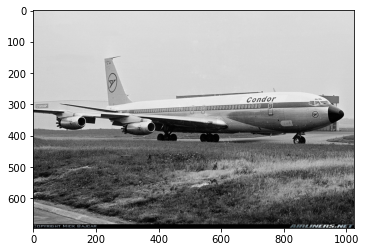

In [82]:
plt.imshow(plt.imread(manufacturer_df.head(1)['path'].values[0]))

In [83]:
# la fonction :
# - prend un df (argument)
# - prend une ligne (row : argument)
# - prend une colonne (target : argument)
# - elle affiche la classe (la valeur de target) et l'image associée, pour la ligne en argument

def show_image(df, row, target ):
    """Show an image from an image database, with the associated class.
    
    Parameters
    ----------
    df (pd.DataFrame): images definition dataframe
    row (int): row index in df of image to be displayed
    target (str): name of the target column
    
    Returns
    -------
    None
    """
    assert target in df.columns, 'Missing target column in dataframe'
    assert 'path' in df.columns, 'Missing image path in dataframe'
    print(df.iloc[row,][target])
    plt.imshow(plt.imread(df.iloc[row,]['path']))
    return

Boeing


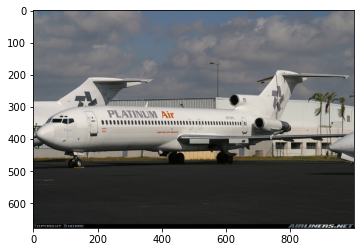

In [84]:
show_image(manufacturer_df, 42, 'manufacturer')

Boeing 727


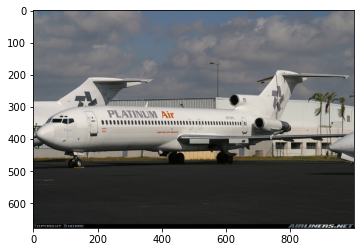

In [85]:
show_image(build_image_database(DATA_DIR / 'images_family_train.txt', 'family'), 42, 'family')

Boeing 707


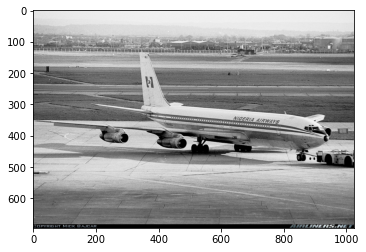

In [86]:
show_image(build_image_database(DATA_DIR / 'images_family_train.txt', 'family'), 24, 'family')

In [87]:
manufacturer_df.shape

(3334, 3)

In [88]:
manufacturer_df.head()

,image_id,manufacturer,path
0,1025794,Boeing,..\data\dataset\data\images\1025794.jpg
1,1340192,Boeing,..\data\dataset\data\images\1340192.jpg
2,0056978,Boeing,..\data\dataset\data\images\0056978.jpg
3,0698580,Boeing,..\data\dataset\data\images\0698580.jpg
4,0450014,Boeing,..\data\dataset\data\images\0450014.jpg


In [89]:
plt.imread(manufacturer_df.head(1)['path'].values[0])

array([[[219, 219, 219],
        [218, 218, 218],
        [219, 219, 219],
        ...,
        [223, 223, 223],
        [222, 222, 222],
        [220, 220, 220]],

       [[217, 217, 217],
        [220, 220, 220],
        [222, 222, 222],
        ...,
        [219, 219, 219],
        [220, 220, 220],
        [222, 222, 222]],

       [[217, 217, 217],
        [221, 221, 221],
        [222, 222, 222],
        ...,
        [221, 221, 221],
        [223, 223, 223],
        [224, 224, 224]],

       ...,

       [[  0,   9,   8],
        [ 58,  70,  82],
        [101, 115, 128],
        ...,
        [  3,   1,   2],
        [  1,   0,   0],
        [  2,   0,   1]],

       [[  0,   2,   0],
        [  1,   2,   4],
        [  0,   2,   1],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  1,   1,   1]],

       [[  4,   0,   1],
        [  4,   0,   4],
        [  6,   0,   4],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [90]:
plt.imread(manufacturer_df.iloc[24,]['path']).shape

(695, 1024, 3)

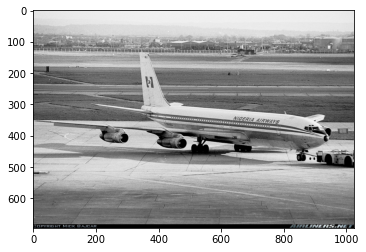

In [91]:
plt.imshow(plt.imread(manufacturer_df.iloc[24,]['path']))

In [92]:
manufacturer_df.head(10)['path'].apply(lambda p: plt.imread(p).shape)

0    (695, 1024, 3)
1    (699, 1024, 3)
2     (687, 913, 3)
3    (678, 1000, 3)
4    (911, 1280, 3)
5    (702, 1024, 3)
6    (679, 1000, 3)
7    (718, 1024, 3)
8    (682, 1005, 3)
9    (678, 1000, 3)
Name: path, dtype: object

In [93]:
manufacturer_df['path'].apply(lambda p: plt.imread(p).shape[0])

0        695
1        699
2        687
3        678
4        911
        ... 
3329    1012
3330     822
3331     679
3332    1012
3333     737
Name: path, Length: 3334, dtype: int64

In [94]:
manufacturer_df['shape_image'] = manufacturer_df['path'].apply(lambda p: plt.imread(p).shape)

In [95]:
manufacturer_df.shape_image

0        (695, 1024, 3)
1        (699, 1024, 3)
2         (687, 913, 3)
3        (678, 1000, 3)
4        (911, 1280, 3)
             ...       
3329    (1012, 1500, 3)
3330     (822, 1200, 3)
3331     (679, 1000, 3)
3332    (1012, 1500, 3)
3333     (737, 1024, 3)
Name: shape_image, Length: 3334, dtype: object

In [96]:
# Distribution du nombre de lignes
manufacturer_df.shape_image.apply(lambda x: x[0]).value_counts()

695     627
812     310
678     271
679     186
694     107
       ... 
845       1
1180      1
1149      1
885       1
482       1
Name: shape_image, Length: 404, dtype: int64

In [98]:
# Distribution du nombre de colonnes
manufacturer_df.shape_image.apply(lambda x: x[1]).value_counts()

1024    1399
1200     618
1000     492
1600     145
1050     105
        ... 
1375       1
993        1
941        1
1013       1
995        1
Name: shape_image, Length: 73, dtype: int64

In [99]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = IMAGE_WIDTH

In [104]:
def load_resize_image(path, height, width):
    """Load an image and resize it to the target size

    Parameters:
    ----------
    path (Path): access path to the image file
    height (int): resize image to this height
    width (int): resize to this width
    
    Returns
    --------
    np.array containing resized image
    """
    return np.array(Image.open(path).resize((width, height)))

In [105]:
manufacturer_df.head(10).apply(lambda r: load_resize_image(r['path'], IMAGE_HEIGHT, IMAGE_WIDTH), axis =1)

0    [[[219, 219, 219], [219, 219, 219], [219, 219,...
1    [[[212, 212, 212], [220, 220, 220], [196, 196,...
2    [[[131, 167, 205], [134, 168, 206], [134, 168,...
3    [[[48, 63, 68], [49, 64, 69], [50, 64, 69], [4...
4    [[[116, 160, 231], [116, 160, 232], [116, 161,...
5    [[[202, 202, 202], [202, 202, 202], [201, 201,...
6    [[[37, 93, 129], [37, 94, 129], [38, 94, 129],...
7    [[[171, 171, 171], [172, 172, 172], [172, 172,...
8    [[[192, 190, 195], [192, 190, 195], [193, 191,...
9    [[[107, 140, 156], [109, 141, 158], [110, 143,...
dtype: object

In [108]:
manufacturer_df['resized_image'] = manufacturer_df.apply(lambda r: load_resize_image(r['path'], IMAGE_HEIGHT, IMAGE_WIDTH), axis =1)

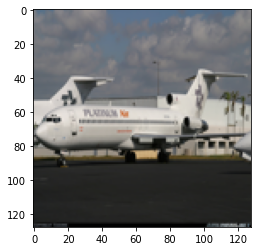

In [111]:
plt.imshow(manufacturer_df.iloc[42,]['resized_image'])

In [97]:
#Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


NameError: name 'X_train' is not defined